In [1]:
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
from stop_words import get_stop_words
#from scipy import sparse
from scipy import spatial
import gensim
import utils
import sys
import string
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as scio
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from utils import random_idx
from utils import utils
from utils import lang_vectors_utils as lvu
from utils import tsne
from tsne import *
%matplotlib inline
tokenizer = RegexpTokenizer(r'\w+')

# create English stop words list
en_stop = get_stop_words('en')

# Create p_stemmer of class PorterStemmer
p_stemmer = PorterStemmer()

num_topics = 50
passes = 20
#topn = 10
k = 5000
N = 10000
# cluster_sizes is mapping to n-gram size
# cluster_sz in random_idx referring to specific element (int) in cluster_sizes, array
cluster_sizes = [1, 2, 3, 4, 5, 6, 7, 8]
ordered = 1
#assuming this is the alphabet bc of precedent in generate_text.py
#alph = 'abc' 
alphabet = string.lowercase + ' '
RI_letters = random_idx.generate_letter_id_vectors(N, k, alphabet)
# words should be unique? (such as permutations)
# number of words added in a syntax vector
syntax_granularities = [100,1000,10000]
lower_n_cutoff = .85
# number of stacked syntax vectors per meaning matrix
meaning_granularities = [10,100,1000,10000]


In [2]:
def create_doc_set(path, files):
    doc_set = []
    for filename in files:
        f = open(path + filename, "r")
        doc_set.append(f.read())
        f.close()
    return doc_set


def tokenize(doc_set):
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]
        # stem tokens
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        # add tokens to list
        texts.append(stemmed_tokens)
    return texts


In [3]:
def meaning_matrix(ldamodel, topicid, topn, dictionary):
    " NO "
    # token 2 id dictionary
    # print dictionary.token2id
    matrix = np.zeros((N,N))
    id2token = dictionary.id2token
    topic_terms = []

    for tup in ldamodel.get_topic_terms(topicid, topn):
        topic_terms.append(str(id2token[tup[0]]))

    for i in range(0,topn):
        term_vector = random_idx.id_vector(N, topic_terms[i], alphabet, RI_letters, ordered)
        matrix[i] = term_vector
    return matrix


def meaning_matrices(ldamodel, num_topics, topn, dictionary):
    " NO "
    matrices = np.zeros((num_topics,N,N))
    for topicid in range(0,num_topics):
        matrices[topicid] = create_meaning_matrix(ldamodel, topicid, topn, dictionary)
    return matrices




In [11]:
def meaning_space(ldamodel, num_topics, dictionary, vectorized_dictionary, syntaxed_space):
    """
    number of granularities meaning space x number of topics x granularity x N
    index in numpy array on axis "number of tokens" equivalent to token id
    """
    # for token ids
    num_tokens = len(dictionary.keys())
    matrices = []
    for gran_i in range(len(meaning_granularities)):
        matrix = np.zeros((num_topics, meaning_granularities[gran_i], N))
        for topicid in range(num_topics):
            terms = ldamodel.get_topic_terms(topicid, meaning_granularities[gran_i])
            for i in range(len(terms)):
                token_id = terms[i][0]
                matrix[topicid][i] = vectorized_dictionary[token_id]
        matrices.append(matrix)
    
    return matrices

In [12]:
# create sample documents
raw_path = "raw_texts/texts_english/"
preprocessed_path = "preprocessed_texts/english/"
training_preprocessed_path = "preprocessed_texts/english/with_spaces/"

training_files = ["a_christmas_carol.txt", "alice_in_wonderland.txt"]
# this is for testing accuracy against the 
# actual stream that will be the test input
test_files = ["hamlet_english.txt", "percy_addleshaw.txt"]

In [13]:
training_doc_set = create_doc_set(training_preprocessed_path, training_files)
test_doc_set = create_doc_set(preprocessed_path, test_files)

tokenized_training_documents = tokenize(training_doc_set)
tokenized_test_documents = tokenize(test_doc_set)

# turn our tokenized documents into a id <-> term dictionary
dictionary = corpora.Dictionary(tokenized_training_documents)
# convert tokenized documents into a document-term matrix
corpus = [dictionary.doc2bow(text) for text in tokenized_training_documents]
# generate LDA model
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=passes)

In [14]:
vectorized_dictionary = vectorize_dictionary(dictionary)

In [ ]:
# meaning matrix
# how to cope with drop out and encoding meaning even tho heavily syntactic bc permutations...
# tokenizing actually gets rid of the permutations...
meaninged_space = meaning_space(ldamodel, num_topics, dictionary, vectorized_dictionary, syntaxed_space)
#print meaninged_space

In [ ]:
def validate_meaning(test_files, tokenized_test_documents, dictionary, meaninged_space, cutoff, meaning_granularities):
    # you can't test a meaning matrix...try graphing first
    """
    meaninged_space dimensions: number of granularities meaning space x number of topics x granularity x N
    prediction_vector = argmax(np.dot(test_token_vector, meaning matrix i))
    graph prediction vector in matplotlib
    N dimensions lmao. how to reduce dimensionality
    """
    # each vector maps to the test_token. dots graphs but mappings can printed
    token_to_id = dictionary.token2id
    # num test_files x number of granularities x number of topics
    # so each topic gets a list of test_token_vectors
    topic_sets = [[[[]*num_topics]*len(meaning_granularities)]*len(test_files)]
    # dictionary of lists of tokens specific to that topic
    topic_to_tokens = {}
    for topicid in range(num_topics):
        topic_to_tokens[topic_id] = []
        
    for i in range(len(test_files)):
        test_tokens = tokenized_test_documents[i]
        for gran_i in range(len(meaning_granularities)):
            for test_token in test_tokens:
                vectorized_test_token = random_idx.id_vector(N, test_token, alphabet, RI_letters)
                # test_token vector will dot product with every matrix 
                # and will match up to a vector in that matrix that would make a high dot product
                prediction_matrix = np.dot(meaninged_space[gran_i], vectorized_test_token)
                topic_similarity = np.zeros(prediction_matrix.shape[0])
                for topicid in range(prediction_matrix.shape[0]):
                    topic_similarity[topicid] = sum(prediction_matrix[topicid])
                matching_topicid = np.argmax(topic_similarity)
                topic_sets[i][gran_i][topicid].append(vectorized_test_token)
                topic_to_tokens[matching_topicid].append(test_token)
    
    return topic_sets, topic_to_tokens
    """
    cluster_min = 4
    cluster_max = 4 # size of max letter cluster
    ordy = [1]
    #lang_map = {'af':'afrikaans','bg':'bulgarian','cs':'czech','da':'danish','nl':'dutch','de':'german','en':'english','et':'estonian','fi':'finnish','fr':'french','el':'greek','hu':'hungarian','it':'italian','pl':'polish','pt':'portuguese','ro':'romanian','sk':'slovak','sl':'slovenian','es':'spanish','sv':'swedish'}
    lang_map = {'af':'afr','bg':'bul','cs':'ces'}#,'da':'dan','nl':'nld','de':'deu','en':'eng','et':'est','fi':'fin','fr':'fra','el':'ell','hu':'hun','it':'ita','lv':'lav','lt':'lit','pl':'pol','pt':'por','ro':'ron','sk':'slk','sl':'slv','es':'spa','sv':'swe'}
    languages = lang_map.values()
    languages.append('nob') #languages.append('norwegian')

    total_vectors = []
    unknown_tots = []
    varys = []

    try:
            unknown_txt = sys.argv[1]
    except IndexError:
            unknown_txt = 'preprocessed_texts/unknown1.txt'

    try:
            new_RI = sys.argv[2]
    except IndexError:
            new_RI = 'on'
    ###############################
    # generate random indexing for letters, reused throughout
    cluster_sizes = xrange(cluster_min,cluster_max+1)
    RI_letters = random_idx.generate_letter_id_vectors(N,k)

    ##############################
    # iterate over cluster sizes
    for cluster_sz in cluster_sizes:
            for ordered in ordy:

                        print "~~~~~~~~~~"
                        # calculate language vectors
                        lang_vectors = random_idx.generate_RI_lang(N, RI_letters, cluster_sz, ordered, languages=languages)
                        total_vectors.append(lang_vectors)

                        # calculate unknown vector
                        unknown_vector = random_idx.generate_RI_text(N, RI_letters, cluster_sz, ordered,unknown_txt)
                        unknown_tots.append(unknown_vector)

                        # print cosine angles 
                        print '=========='
                        if ordered == 0:
                                ord_str = 'unordered!'
                        else:
                                ord_str = 'ordered!'

                        print 'N = ' + str(N) + '; k = ' + str(k) + '; letters clusters are ' + str(cluster_sz) + ', ' + ord_str + '\n'
                        cosangles = utils.cosangles(lang_vectors, languages)
                        variance = utils.var_measure(cosangles)
                        varys.append(variance)
                        print "variance of language values: " + str(utils.var_measure(cosangles))

    #############################
    # final language vector calculations!

    final_lang = sum(total_vectors)
    final_unknown = sum(unknown_tots)

    print '\n'
    # compare with "unknown text"
    #final_unknown = sum(unknown_tots)
    utils.find_language(unknown_txt, final_unknown, final_lang, languages, display=1)

    print '========='
    print 'N = ' + str(N) + '; k = ' + str(k) + '; max size letters clusters are ' + str(cluster_max) + '\n'
    cosangles = utils.cosangles(final_lang, languages, display=0)
    print "variance of language values: " + str(utils.var_measure(cosangles))

    # plot language points
    plt.figure()
    Y = tsne(cosangles,no_dims=2,initial_dims=100,perplexity=8)
    plt.scatter(Y[:,0],Y[:,1])#,len(languages),np.r_[1:len(languages)])
    for label, x, y in zip(languages, Y[:, 0], Y[:, 1]):
        plt.annotate(
            label, 
            xy = (x, y), xytext = (-20, 20),
            textcoords = 'offset points', ha = 'right', va = 'bottom',
            bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
            arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'),
                    fontsize='x-large')
    frame = plt.gca()
    frame.axes.get_xaxis().set_ticks([])
    frame.axes.get_yaxis().set_ticks([])
    plt.show()
    """

validate_meaning()

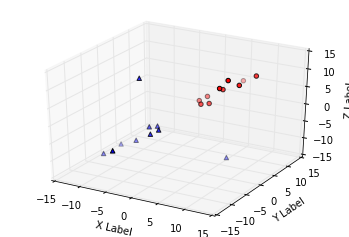

In [3]:
def graphing_3d():
    # each vector maps to the test_token. dots graphs but mappings can printed
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    xs =[1,2,3,4,5,6,7,8,9,10]
    ys =[5,6,2,3,13,4,1,2,4,8]
    zs =[2,3,3,3,5,7,9,11,9,10]

    xt =[-1,-2,-3,-4,-5,-6,-7,8,-9,-10]
    yt =[-5,-6,-2,-3,-13,-4,-1,2,-4,-8]
    zt =[-2,-3,-3,-3,-5,-7,9,-11,-9,-10]

    ax.scatter(xs, ys, zs, c='r', marker='o')
    ax.scatter(xt, yt, zt, c='b', marker='^')

    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')

    plt.show()